## 9.4 锚框

以每个像素为中心生成多个大小和宽高比不同的边界框，这些（单组多个）边界框组成了锚框。

所谓的大小是指相对于原图的宽高比的1/x;
所谓的宽高比是指生成的边界框的宽/高之比.

In [77]:
from PIL import Image
import numpy as np
import math
import torch

import sys
sys.path.append('../d2lzh/')
import d2lzh_pytorch as d2l
print(torch.__version__)

1.3.1


### 1. 如何生成锚框？

#### 全部枚举

假设输入图像高为$h$,宽为$w$，设生成的锚框大小为$s\in \left( 0,1 \right]$，宽高比为$r \gt 0$. 则锚框的宽为$ws\sqrt r$，高为$\frac{hs}{\sqrt r}$.

一组锚框的大小为$s_1, s_2, \dots ,s_n$，一组锚框的宽高比为$r_1, r_2, \dots, r_m$，则单个像素所对应的锚框个数为$n\times m$，整张输入图像所对应的锚框个数为$h\times w \times n \times m$.尽管这样能保证将真实边界框包含在内，但一旦input图像非常大，那么计算复杂度将会很高。

#### 如何解决？

常用的做法是，对某个坐标，我们不关注它所有可能锚框的组合，而只关注包含了或$s_1$、或$r_1$的锚框，把它们列出来，就是

$$ \left( s_1, r_1 \right), \left( s_1, r_2 \right), \dots, \left( s_1, r_m \right), \left(s_2, r_1 \right), \left( s_3, r_1  \right), \dots, \left( s_n, r_1  \right). $$

此时，单像素所对应的锚框个数只有$n+m-1$个，对整张图像来说，只有$hw\left(n+m-1  \right)$个。

### 例子

#### 如何生成一组锚框？

In [78]:
d2l.set_figsize()
img = Image.open('../Datasets/catdog.jpg')
w, h = img.size
print("w = %d, h = %d" % (w, h))   # w = 299, h = 231

def MultiBoxPrior(feature_map, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5]):
    '''
    Function:
        输出给定输入fmap的bounding boxes
    Args:
        feature_map: torch tensor, Shape: [N, C, H, W].
        sizes: List of sizes (0~1) 
        ratios: List of aspect ratios (non-negative) 
    Returns:
        anchors of shape (1, num_anchors, 4). # batch, num_anc, positions
    '''
    # s与r的组合
    pairs = []
    for r in ratios:
        pairs.append([sizes[0], math.sqrt(r)]) # 首先保证有s_1
    for s in sizes[1:]:
        pairs.append([s, math.sqrt(ratios[0])]) # 其次要保证有r_1

    pairs = np.array(pairs)
#     print(pairs)
    
    ss1 = pairs[:, 0] * pairs[:, 1] # size * sqrt(ratio)
    ss2 = pairs[:, 0] / pairs[:, 1] # size / sqrt(ratio)
#     print(ss1)
#     print(ss2)
    
    base_anchors = np.stack([-ss1, -ss2, ss1, ss2], axis=1) / 2
    print(base_anchors)
    
    h, w = feature_map.shape[-2:]
    shifts_x = np.arange(0, w) / w
#     print(shifts_x)
    shifts_y = np.arange(0, h) / h
    shift_x, shift_y = np.meshgrid(shifts_x, shifts_y)
    shift_x = shift_x.reshape(-1)
#     print(shift_x.shape)
    shift_y = shift_y.reshape(-1)
#     print(shift_y.shape)  # (69069,)
    shifts = np.stack((shift_x, shift_y, shift_x, shift_y), axis=1)
    
    anchors = shifts.reshape((-1, 1, 4)) + base_anchors.reshape((1, -1, 4))
        
    return torch.tensor(anchors, dtype=torch.float32).view(1, -1, 4)

X = torch.Tensor(1, 3, h, w) # 构造输入数据
Y = MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape # torch.Size([1, 345345, 4])    

## 上面的返回的锚框变量其形状为(1, 总的锚框个数， 4个指示的坐标位置)，
## 将返回值转换为格式（原图的高，原图的宽，以其中某一像素为中心的锚框个数，4）,
## 那么，就可以通过某个像素的坐标位置来的得到它的所有锚框了。

boxes = Y.reshape((h, w, 5, 4))
boxes[20, 200, 0, :]  
# 坐标位置为(20, 200)的像素所对应的第0个锚框,返回锚框的四个坐标(左上x和y、右下x和y)
# tensor([ 0.2939, -0.2884,  1.0439,  0.4616]) 如何理解?
# 这四个坐标已经除以图像的高和宽，因此值在0到1之间
# 即0.2939和1.0439已经除了width,-0.2884和0.4616已经除了height.

## 那么这些数值又是怎样联系到sizes和ratios的呢？ 
# 第一个锚框的sizes[0]=0.75， retios[0]=1, 即1.0439-0.2939=0.4616+0.2884， 两者相等

boxes[20, 200, 1, :]  
# tensor([ 0.1386, -0.1786,  1.1992,  0.3517])
# 第2个锚框的sizes[0]=0.75， retios[1]=2, 即1.1992-0.1386=(0.3517+0.1786)*2， 两者相等


w = 728, h = 561
[[-0.375      -0.375       0.375       0.375     ]
 [-0.53033009 -0.26516504  0.53033009  0.26516504]
 [-0.26516504 -0.53033009  0.26516504  0.53033009]
 [-0.25       -0.25        0.25        0.25      ]
 [-0.125      -0.125       0.125       0.125     ]]


tensor([-0.2556, -0.2295,  0.8051,  0.3008])

In [13]:
### 描绘以某个像素为中心的所有锚框在input上

In [46]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = _make_list(labels)
    colors = _make_list(colors, ['b','g','r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().cpu().numpy(), color)
        axes.add_patch(rect)  # 先画出一个框
        if labels and len(labels) > i:  # 标注文字、颜色等
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], # 位置x
                      rect.xy[1], # 位置y
                      labels[i],  # 文字
                      va='center', # 
                      ha='center', 
                      fontsize=6, 
                      color=text_color,
                      bbox=dict(facecolor=color, lw=0)
                     )

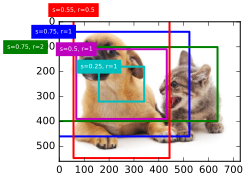

In [49]:
d2l.set_figsize()
fig = d2l.plt.imshow(img)
bbox_scale = torch.tensor([[w, h, w, h]], dtype=torch.float32)
labels=['s=0.75, r=1', 
        's=0.75, r=2', 
        's=0.55, r=0.5', 
        's=0.5, r=1', 
        's=0.25, r=1']
show_bboxes(fig.axes, bboxes=boxes[250, 250, :, :] * bbox_scale, labels=labels)

d2l.plt.show()

### 2. 交并比(intersection over union, IoU)

也称为Jaccard系数

给定集合$\mathcal{A}$和集合$\mathcal{B}$，Jaccard系数等于

$$ J\left( \mathcal{A}, \mathcal{B}\right)=\frac{\left\vert \mathcal{A} \cap \mathcal{B} \right\vert}{\left\vert\mathcal{A} \cup \mathcal{B} \right\vert} , $$

亦将这个系数称之为交并比（Intersection over Union，IoU），它是两个边界框相交面积与相并面积之比。

In [2]:
def compute_intersection(set_1, set_2):
    """
    计算anchor之间的交集
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1),
                            set_2[:, :2].unsqueeze(0))  # (n1,n2,2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1),
                            set_2[:, 2:].unsqueeze(0))  # (n1,n2,2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1,n2,2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]   # (n1,n2)
    
def compute_jaccard(set_1, set_2):
    """
    计算anchor之间的Jaccard系数(IoU)
    Args:
        set_1: a tensor of dimensions (n1, 4), anchor表示成(xmin, ymin, xmax, ymax)
        set_2: a tensor of dimensions (n2, 4), anchor表示成(xmin, ymin, xmax, ymax)
    Returns:
        Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, shape: (n1, n2)
    """
    # find intersections
    intersection = compute_intersection(set_1, set_2)  # (n1, n2)
    print(intersection.shape)
    
    # find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    
    # find the union
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)
    
    return intersection / union # (n1, n2)


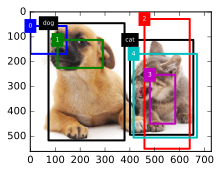

In [54]:
bbox_scale = torch.tensor((w, h, w, h), dtype=torch.float32)
ground_truth = torch.tensor([
        [0, 0.1, 0.08, 0.52, 0.92],
        [1, 0.55, 0.2, 0.9, 0.88]
    ])
anchors = torch.tensor([
        [0, 0.1, 0.2, 0.3],
        [0.15, 0.2, 0.4, 0.4],
        [0.63, 0.05, 0.88, 0.98],
        [0.66, 0.45, 0.8, 0.8],
        [0.57, 0.3, 0.92, 0.9],
    ])
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4'])

d2l.plt.show()

### 3 标注训练集的锚框

上面已经讨论过了，如何生成一组锚框、如何计算jaccard系数。那么，给定训练数据集，应该如何生成训练样本呢？如何理解网络的输入、输出？

** 训练流程: **

1. 给定训练数据集(以其中一张图片为例), 每张图片已经标注类别和真实边界框；
2. 生成多组锚框，通过计算jaccard表，为每个锚框标注两类标签：类别、真实框相对锚框的偏移量（offset)
3. 训练目标是预测类别+预测偏移量

** 问题1 **：
准备训练数据集时，如何为锚框分配真实边界框？


**回答1**：

假设有$A_{n_a}$个锚框，有$B_{n_b}$个真实边界框。则生成的jaccard系数表矩阵为$X \in \mathbb{R}^{n_a \times n_b}$. 对这个矩阵，首先找出最大的一个系数值，随后将它的所在行所在列清空，代表已经为该锚框分配了真实边界框。随后在剩下的系数表继续找最大值，将其所在行所在列清空。依次类推。当整张表格都被清空后，也就代表已经为${n_b}$个锚框分配了真实边界框。还有${n_a-n_b}$个锚框有待分配真实边界框。

对这些剩下的边界框，逐一遍历系数表每一行（每个边界框与真实边界框之间的jaccard系数），找到最大值，如果该最大值比预先设定的阈值还小，则不为该锚框设定类别（将其mask设为0），否则将其设置为对应列所对应的真实边界框。


** 问题2 **：
锚框与真实边界框之间的offset如何定义？

**回答2 **：

设锚框$A$的中心坐标为:$\left( x_a,y_a \right)$, 宽:$w_a$, 高:$h_a$

真实边界框的中心坐标为$\left( x_b,y_b \right)$, 宽:$w_b$, 高:$h_b$，那么，可以将$A$的偏移量标注为：

$$ \left( \frac{\frac{x_b-x_a}{w_a} - \mu_{x}}{\sigma_{x}}   ,  \frac{\frac{y_b-y_a}{h_a} - \mu_{y}}{\sigma_{y}} ,  \frac{\log{\frac{w_b}{w_a}} - \mu_{w}}{\sigma_{w}} ,  \frac{\log{\frac{h_b}{h_a}} - \mu_{h}}{\sigma_{h}}   \right), $$

In [55]:
def assign_anchor(bb, anchor, jaccard_threshold=0.5):
    """
    为每个anchor分配真实的bb,依据是jaccard系数/iou
    Args:
        bb: 真实边界框(bounding box), shape:（nb, 4）
        anchor: 待分配的anchor, shape:（na, 4）
        jaccard_threshold: 预先设定的阈值
    Returns:
        assigned_idx: shape: (na, ), 每个anchor分配的真实bb对应的索引, 若未分配任何bb则为-1
    """
    na = anchor.shape[0]
    nb = bb.shape[0]
    jaccard = compute_jaccard(anchor, bb).detach().cpu().numpy() # R^{anchor x bb}
    assigned_idx = np.ones(na) * -1  # 为每一个anchor分配一个bb的id,初始值-1
    
    # 先为每个bb分配一个anchor
    jaccard_cp = jaccard.copy()
    for j in range(nb):
        i = np.argmax(jaccard_cp[:, j]) # 第j个真实边界框索引找到最大的jaccard
        assigned_idx[i] = j
        jaccard_cp[i, :] = float("-inf") # 相当于永远不会再索引该行（因为已经分配完毕）
        
    # 对其他未得到分配的anchor来说，再次分配，需要考虑jaccard_threshold
    for i in range(na):
        if assigned_idx[i] == -1: # 通过索引该数组确定jaccard矩阵内的分配情况
            j = np.argmax(jaccard[i, :])
            if jaccard[i, j] >= jaccard_threshold:
                assigned_idx[i] = j

    return torch.tensor(assigned_idx, dtype=torch.long)


def xy_to_cxcy(xy):
    """
     将(x_min, y_min, x_max, y_max)形式的anchor转换成(center_x, center_y, w, h)形式的.
    Args:
        xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    Returns: 
        bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    
    """
    
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2, # center_x, center_y
                     xy[:, 2:] - xy[:, :2]], 1)  # w, h

def MultiBoxTarget(anchor, label):
    """
    Function:
        为anchor分配真实的label. 这里的anchor和label信息更复杂。
    Args:
        anchor: torch tensor, 输入的锚框, 一般是通过MultiBoxPrior生成, shape:（1，锚框总数，4）
        label: 真实标签, shape为(bn, 每张图片最多的真实锚框数, 5)
               第二维中，如果给定图片没有这么多锚框, 可以先用-1填充空白, 最后一维中的元素为[类别标签, 四个坐标值]
    Returns:
        列表, [bbox_offset, bbox_mask, cls_labels]
        bbox_offset: 每个锚框的标注偏移量，形状为(bn，锚框总数*4)
        bbox_mask: 形状同bbox_offset, 每个锚框的掩码, 一一对应上面的偏移量, 负类锚框(背景)对应的掩码均为0, 正类锚框的掩码均为1
        cls_labels: 每个锚框的标注类别, 其中0表示为背景, 形状为(bn，锚框总数)
    """
    
    assert len(anchor.shape) == 3 and len(label.shape) == 3
    bn = label.shape[0]
    
    def MultiBoxTarget_one(anc, lab, eps=1e-6):
        """
        Function:
            MultiBoxTarget函数的辅助函数, 处理batch中的一个
            给定ancs, 给定label, 根据 assign_anchor函数所给定的索引 来计算每个anc的类别、偏移量和mask
        Args:
            anc: shape of (锚框总数, 4)
            lab: shape of (真实锚框数, 5), 5代表[类别标签, 四个坐标值]
            eps: 一个极小值, 防止log0
        Returns:
            offset: (锚框总数*4, )
            bbox_mask: (锚框总数*4, ), 0代表背景, 1代表非背景
            cls_labels: (锚框总数, 4), 0代表背景
        """
        an = anc.shape[0]

        assigned_idx = assign_anchor(lab[:, 1:], anc) # (锚框总数, )
        bbox_mask = ((assigned_idx >= 0).float().unsqueeze(-1)).repeat(1, 4) # (锚框总数, 4)        
        cls_labels = torch.zeros(an, dtype=torch.long)
        assigned_bb = torch.zeros((an, 4), dtype=torch.float32)
        
        for i in range(an):
            bb_idx = assigned_idx[i]
            if bb_idx >= 0:
                cls_labels[i] = lab[bb_idx, 0].long().item() + 1
                assigned_bb[i, :] = lab[bb_idx, 1:]
                
        center_anc = xy_to_cxcy(anc)
        center_assigned_anc = xy_to_cxcy(assigned_bb)
        
        offset_xy = 10.0 * (center_assigned_anc[:, :2] - center_anc[:, :2]) / center_anc[:, 2:]
        offset_wh = 5.0 * (center_assigned_anc[:, 2:] - center_anc[:, 2:]) / center_anc[:, 2:]
        offset = torch.cat([offset_xy, offset_wh], dim=1) * bbox_mask
        
        return offset.view(-1), bbox_mask.view(-1), cls_labels
    
    batch_offset = []
    batch_mask = []
    batch_cls_labels = []
    for b in range(bn):
        offset, bbox_mask, cls_label = MultiBoxTarget_one(anchor[0, :, :], label[b, :, :])
        
        batch_offset.append(offset)
        batch_mask.append(bbox_mask)
        batch_cls_labels.append(cls_label)
        
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    cls_labels = torch.stack(batch_cls_labels)
    
    return [bbox_offset, bbox_mask, cls_labels]   
        

In [56]:
labels = MultiBoxTarget(anchors.unsqueeze(dim=0), ground_truth.unsqueeze(dim=0))

torch.Size([5, 2])


In [57]:
labels[2]  # 第三项表示为锚框标注的类别。

tensor([[0, 1, 2, 0, 2]])

In [58]:
labels[1]  # 第二项为mask.

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

In [59]:
labels[0]  # 偏移量，负类锚框的偏移量为零

tensor([[-0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,  1.4000e+00,
          1.0000e+01,  3.4000e+00,  1.6000e+01, -1.2000e+00,  2.6882e-01,
          2.0000e+00, -1.3441e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         -0.0000e+00, -5.7143e-01, -1.0000e+00, -8.5149e-07,  6.6667e-01]])

### 4. 输出预测边界框

** 测试流程: **
1. 输入test图片, 生成若干锚框;
2. 预测锚框所属类别、offset;
3. 类别无需改变，而锚框往offset方向作相应移动
4. 筛选预测边界框（非极大值抑制（non-maximum suppression，NMS）；
5. 输出预测类别和预测边界框

** NMS工作流程 **

1. 材料：（1）预测边界框（共$n_a$行）和类别（共$n_b$列）构成的预测概率表；（2）预测边界框与预测边界框构成的jaccard表。
2. 将预测概率表按置信度从大到小进行排序，得到L表。
3. 以最大置信度对应的预测边界框作为基准。
4. 预先设定一个阈值，所有与基准边界框构成的jaccard系数大于该阈值，则将那些非基准边界框从L中移出。
5. 从L中选取第二高的置信度值，以该值对应的预测边界框作为基准，再次在jaccard表中筛选。
6. 依次类推，直到L中所有预测边界框都曾作为基准，L中任意一对边界框之间在jaccard表中都会小于特定阈值（即它们之间表示同一个目标的概率较低）

In [63]:
anchors = torch.tensor([           # 1.生成锚框
        [0.1, 0.08, 0.52, 0.92],
        [0.08, 0.2, 0.56, 0.95],
        [0.15, 0.3, 0.62, 0.91],
        [0.55, 0.2, 0.9, 0.88],
    ])
offset_preds = torch.tensor([0.0] * (4 * len(anchors)))
cls_probs = torch.tensor([
        [0., 0., 0., 0.], # 背景的预测概率
        [0.9, 0.8, 0.7, 0.1], # 狗的预测概率
        [0.1, 0.2, 0.3, 0.9], # 猫的预测概率
    ])

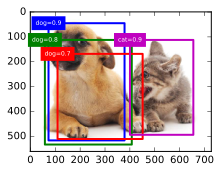

In [64]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
           ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])
d2l.plt.show()

In [69]:
from collections import namedtuple
Pred_BB_Tuple = namedtuple("Pred_BB_Tuple", ["index", 'class_id', 'confidence', 'xyxy'])

def non_max_suppression(bb_info_list, nms_threshold=0.5):
    """
    函数：给定预测边界框，将相似的预测边界框剔除
    Args:
        bb_info_list: Pred_BB_Tuple列表，包含类别，置信度，坐标值等信息
        nms_threshold: 每循环一次，小于该值的bb得以保留做下一轮循环
        
    Output：
        output: 经过筛选后的预测边界框    
    """
    
    output = []
    # 根据置信度大小，排序
    sorted_bb_info_list = sorted(bb_info_list, key=lambda x: x.confidence, reverse=True)
    
    while(len(sorted_bb_info_list) != 0):
        best = sorted_bb_info_list.pop(0)  # 拿出第一个置信度最高的bb_list
        output.append(best)
        
        if len(sorted_bb_info_list) == 0:
            break
            
        # 为计算iou做准备
        bb_xyxy = []
        for bb in sorted_bb_info_list:
            bb_xyxy.append(bb.xyxy)
            
        # 计算iou, 计算预测边界框之间的交并比,为剔除做准备
        iou = compute_jaccard(torch.tensor([best.xyxy]), torch.tensor(bb_xyxy))[0]
        
        # 根据计算得到的iou进行非极大值抑制
        n = len(sorted_bb_info_list)
        sorted_bb_info_list = [sorted_bb_info_list[i] for i in range(n) if iou[i] <= nms_threshold]
        
    return output
            
def MultiBoxDetection(cls_prob, loc_pred, anchor, nms_threshold=0.5):
    """
    Function:
        将原生锚框和预测概率+预测偏移量进行整合，输出的是经过系统认证的（预测框+预测类别+预测置信度等信息）
    Args:
        cls_prob: 经过softmax后得到的各个锚框的类别预测概率, shape:(bn, 预测总类别数+1, 锚框个数)
        loc_pred: 预测的各个锚框的偏移量, shape:(bn, 锚框个数*4)
        anchor: MultiBoxPrior输出的默认锚框, shape: (1, 锚框个数, 4),anchor表示成归一化(xmin, ymin, xmax, ymax).
        nms_threshold: 非极大抑制中的阈值
    Returns:
        所有锚框的信息, shape: (bn, 锚框个数, 6)
        每个锚框信息由[class_id, confidence, xmin, ymin, xmax, ymax]表示
        class_id=-1 表示背景或在非极大值抑制中被移除了
    """
    assert len(cls_prob.shape) == 3 and len(loc_pred.shape) == 2 and len(anchor.shape) == 3
    
    bn = cls_prob.shape[0]
    
    def MultiBoxDetection_one(c_p, l_p, anc, nms_threshold=0.5):
        """
        MultiBoxDetection的辅助函数, 处理batch中的一个
        Args:
            c_p: (预测总类别数+1, 锚框个数)
            l_p: (锚框个数*4, )
            anc: (锚框个数, 4)
            nms_threshold: 非极大抑制中的阈值
        Return:
            output: (锚框个数, 6)
        """
        
        pred_bb_num = c_p.shape[1]
        anc = (anc + l_p.view(pred_bb_num, 4)).detach().cpu().numpy()
        
        confidence, class_id = torch.max(c_p, 0)   # (1, 锚框个数)
        confidence = confidence.detach().cpu().numpy()
        class_id = class_id.detach().cpu().numpy()
        
        pred_bb_info = [Pred_BB_Tuple(
                            index = i,
                            class_id = class_id[i] - 1,
                            confidence = confidence[i],
                            xyxy = [*anc[i]])
                       for i in range(pred_bb_num)
                       ]
        # 正类的index
        obj_bb_idx = [bb.index for bb in non_max_suppression(pred_bb_info, nms_threshold)]
        
        output = []  # 容纳筛选后的预测边界框
        for bb in pred_bb_info:
            output.append([
                    (bb.class_id if bb.index in obj_bb_idx else -1.0),
                    bb.confidence,
                    *bb.xyxy
                ])
            
        return torch.tensor(output) # shape: (锚框个数， 6)
        
    batch_output = []
    for b in range(bn):
        batch_output.append(MultiBoxDetection_one(cls_prob[b], loc_pred[b], anchor[0], nms_threshold))
        
    return torch.stack(batch_output)
        

torch.Size([3, 4])
torch.Size([16])
torch.Size([4, 4])
torch.Size([1, 3])
tensor([[[ 0.0000,  0.9000,  0.1000,  0.0800,  0.5200,  0.9200],
         [-1.0000,  0.8000,  0.0800,  0.2000,  0.5600,  0.9500],
         [-1.0000,  0.7000,  0.1500,  0.3000,  0.6200,  0.9100],
         [ 1.0000,  0.9000,  0.5500,  0.2000,  0.9000,  0.8800]]])
torch.Size([1, 4, 6])


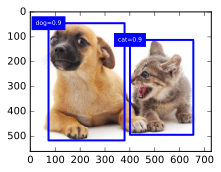

In [75]:
print(cls_probs.shape)
print(offset_preds.shape)
print(anchors.shape)

output = MultiBoxDetection(
    cls_probs.unsqueeze(dim=0),
    offset_preds.unsqueeze(dim=0),
    anchors.unsqueeze(dim=0),
    nms_threshold=0.5
)

print(output)
print(output.shape) # shape:(1,4,6), 其中第二维是样本数，第三维为(类别，置信度，框坐标（4个））

# 剔除背景框（类别为-1的预测边界框）, 并可视化其他预测边界框
fig = d2l.plt.imshow(img)
for i in output[0].detach().cpu().numpy():
    if i[0] == -1: continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1]) # 0为dog, 1为cat
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)
d2l.plt.show()

### 小结

* 以每个像素为中心，生成多个大小和宽高比不同的锚框。
* 交并比是两个边界框相交面积与相并面积之比。
* 在训练集中，为每个锚框标注两类标签：一是锚框所含目标的类别；二是真实边界框相对锚框的偏移量。
* 预测时，可以使用非极大值抑制来移除相似的预测边界框，从而令结果简洁。